In [20]:
import tensorflow as tf
import tensorflow_probability as tfp
from Models.parallel_model import ParallelModel
import numpy as np
from flow import Flow
from estimator import ImportanceSampling

In [21]:
def create_base_model(input_shape=1, output_shape=1):
    inputs = tf.keras.Input(shape=(input_shape,))
    x = tf.keras.layers.Dense(512, activation='relu')(inputs)
    x = tf.keras.layers.Dense(256, activation='relu')(x)
    outputs = tf.keras.layers.Dense(output_shape, activation='tanh')(x)
    return tf.keras.Model(inputs, outputs)


In [22]:
base_model = create_base_model()
parallel_model = ParallelModel(base_model, 10)

In [53]:
flow = Flow(
    prior = None,
    likelihood_std=0.1, 
    k=1.0,
    n_epochs_recorded= 5
)

In [24]:
X_train = tf.cast(np.linspace(0, 1, 1000).reshape(-1, 1), tf.float32)
y_train = tf.cast(np.sin(X_train * 2 * np.pi).reshape(-1, 1), tf.float32)

In [ ]:
flow.compile(
    optimizer=tf.keras.optimizers.Adam(0.001),
    metrics=['accuracy']
)

deep_ensemble = flow.flow(
    model = parallel_model,
    x = X_train,
    y = y_train,
    batch_size = 128,
    epochs=100,
    estimator = "deep_ensemble")

Training Epochs:   0%|          | 0/200 [00:00<?, ?epoch/s]

In [55]:
importance_sampling = flow.get_estimator("importance_sampling")

In [56]:
x_pred = np.linspace(0, 1, 100)
mean_De, var_De = deep_ensemble(x_pred.reshape(-1, 1))
mean_IS, var_IS = importance_sampling(x_pred.reshape(-1, 1))


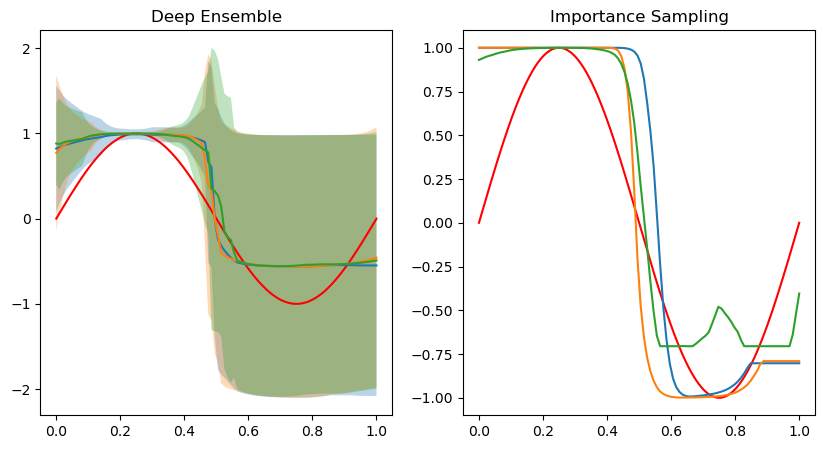

In [57]:
import matplotlib.pyplot as plt


fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (10, 5))
# i=2
ax1.plot(X_train, y_train, label='true', color = "red")
ax2.plot(X_train, y_train, label='true', color = "red")
ax1.set_title('Deep Ensemble')
ax2.set_title('Importance Sampling')

for i in range(0, len(mean_De), 2):
    ax1.plot(x_pred, mean_De[i])
    ax1.fill_between(x_pred, mean_De[i] - 1.96*np.sqrt(var_De[i]), mean_De[i] + 1.96*np.sqrt(var_De[i]), alpha = 0.3)
    ax2.plot(x_pred, mean_IS[i])
    ax2.fill_between(x_pred, mean_IS[i] - 1.96*np.sqrt(var_IS[i]), mean_IS[i] + 1.96*np.sqrt(var_IS[i]), alpha = 0.3)
plt.show()